# Facial Expression Recognition Challenge using Convolutional Neural Network

## Abstract

Recently, I have developed a mobile game, [Best Actor](https://github.com/mikemikezhu/best-actor-ios), which uses computer vision model to recognize facial expressions. Specifically, the mobile game will randomly display a facial expression label (e.g. surprise) to the player. And the player has to mimic the facial expression so as to achieve a high score. Here I have designed a Convolutional Neural Network in order to perform facial expression recognition in the mobile game. This document will discuss the design and implementation details of the computer vision model.

## Computer Vision

### Download Data

Considering that the mobile game relies on computer vision model to make predictions on human facial expressions, we need to download the dataset to train the computer vision model. Here we use FER2013 dataset in [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) in Kaggle. Therefore, let's configure Kaggle API and download the training dataset.

### Load Data

The image dataset downloaded from Kaggle is in ".csv" file format. Therefore, we need to load the "train.csv" file, and convert it to numpy array. The training images and labels are saved in "x_train" and "y_train" respectively.

In [12]:
import csv
import numpy

train_images = []
train_labels = []
path_train = "emotion-detection-fer/train/"

categories_count = {}
def create_training_data():
    for category in classer:
        path = os.path.join(path_train, category)
        class_num = classer.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            new_array = cv2.resize(img_array, (img_size, img_size))
            training_data.append([new_array, class_num])
with open('fer2013.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (35887, 48, 48)
y_train shape: (35887,)


The image dataset provided by Kaggle contains 7 different facial expression categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The distogram of the facial expression categories is displayed as follows.

In [13]:
print(x_train[0])

[[ 70  80  82 ...  52  43  41]
 [ 65  61  58 ...  56  52  44]
 [ 50  43  54 ...  49  56  47]
 ...
 [ 91  65  42 ...  72  56  43]
 [ 77  82  79 ... 105  70  46]
 [ 77  72  84 ... 106 109  82]]


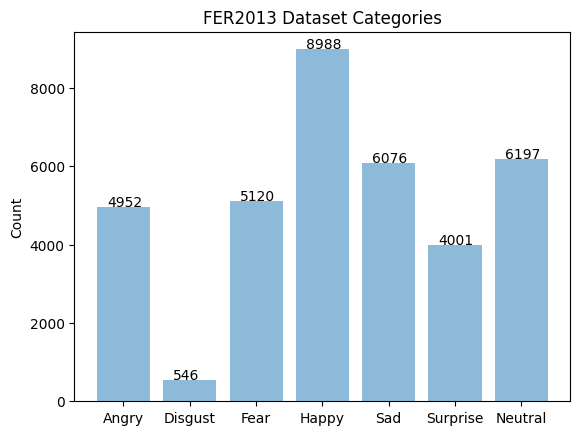

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)
    plt.text(label - 0.25, count + 15, str(count))

# Draw histogram
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

Then, let's show one of the images in the dataset. Each image is grey-scale and contains 48 x 48 pixels.

Label is: 0


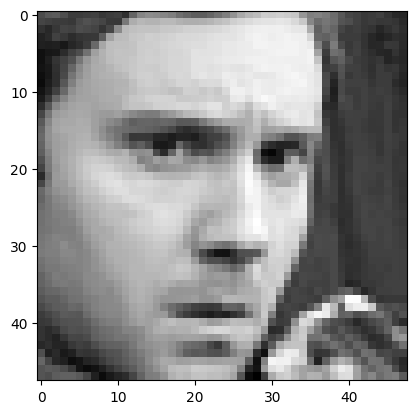

In [15]:
image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

### Preprocess Data

Next, we need to split the dataset into training set and test set. Here, we choose 20% of the dataset as test set, and the rest of the dataset as train set.

In [16]:
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(28709, 48, 48, 1)
(7178, 48, 48, 1)


### Train Model

Next, we need to train the model with the image dataset. Here we use Tensorlow as backend to train the model. Therefore, we need to import all the required packages before the training process.

In [17]:
# %tensorflow_version 2.x
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Tensorflow version: 2.16.1


By referring to VGGNet architecture, we have designed the computer vision model with several stacks of layers. The model will have the following components:
- Convolutional layers: These layers are the building blocks of our architecture, which learns the image feature by computing the dot product between the weights and the small region on the image. Similar to VGGNet architecture, all the convolutional layers are designed with 3 x 3 kernal size, and several filters.
- Activation functions: The activation functions are those functions which are applied to the outputs of the layers in the network. Specifically, we use ReLU (Rectified Linear Unit) activation function to increase the non-linearity of the network. Besides, a Softmax function will be used to compute the probability of each category.
- Pooling layers: These layers will down-sample the image to reduce the spatial data and extract features. In our model, we will use Max Pooling with A 3 x 3 pooling size and a 2 x 2 stride.
- Dense layers: The dense layers are stacked as the fully connected layers of the network, which take in the feature data from the previous convolutional layers and perform decision making.
- Dropout layers: The dropout layers are used to prevent over-fitting when training the model.
- Batch normalization: This technique can be used to speed up learning by normalizing the output of the previous activation layer.

The diagram of the model is displayed as follows.

![cnn](https://drive.google.com/uc?id=1jjORxRgvEDDMLZ-mX5JkCnUWUFn7IHpL)

Our model contains 5 stacks of layers. In each of the first 4 stacks of layers, there are 2 convolutional layer followed by 1 pooling layer. Besides, we use batch normalization to speed up training and dropout to prevent over-fitting. Then we have one stack of 3 fully-connected layers, followed by a Softmax activation function, which generates the probability of the facial expression categories. Finally, we compile our model using Adam optimizer with a certain learning rate. Considering that we are dealing with classification issue, we will use `sparse_categorical_crossentropy` as the loss function.

In [18]:
cnn_model = Sequential()

# 1st convolution layer
cnn_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 2nd convolution layer
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 3rd convolution layer
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# 4th convolution layer
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model.add(Dropout(0.3))

# Fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))

cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
cnn_model.summary()

c:\Zio7\Envi\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,102,791 (19.47 MB)

 Trainable params: 5,098,951 (19.45 MB)

 Non-trainable params: 3,840 (15.00 KB)

Next, we will train our model. Here we use Early Stopping strategy, which will stop the training process when there is no improvement in the validation accuracy. Besides, we will also reduce the learning rate by a specific factor if there is a plateau is detected in the validation loss.

In [19]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = cnn_model.fit(x_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 270s 591ms/step - accuracy: 0.2137 - loss: 2.0292 - val_accuracy: 0.2003 - val_loss: 2.0015 - learning_rate: 0.0010
Epoch 2/100
 67/449 ━━━━━━━━━━━━━━━━━━━━ 3:25 538ms/step - accuracy: 0.2703 - loss: 1.8032

KeyboardInterrupt: 

After the training process is completed, let's display the accuracy diagram of the training accuracy and validation accuracy.

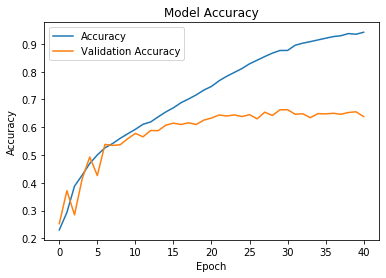

In [ ]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

### Improve Model

We will try to improve our model to increase the validation accuracy. Here we have used the following techniques in our model improvement:
- Generate hard data
- Data augmentation

Before we improve our model, let's evaluate our model by using test set. We can see the score before improvement is around 64%.

In [ ]:
# Evaluate the model before improvement
_, score_before_improvement = cnn_model.evaluate(x_test, y_test)
print('Score before improvement: {}'.format(score_before_improvement))

5742/5742 [==============================] - 2s 337us/sample - loss: 1.9947 - accuracy: 0.6383
Score before improvement: 0.6382793188095093


Next, we will improve our model by generating hard data. Specifically, instead of training the model over and over again, we will select the images which are incorrectly labelled by the model, and train the model on these specific images. Therefore, let's use our model to make predictions first, and put the incorrect ones into the array of hard data for further training.

In [ ]:
# Generate hard data
hard_images = []
hard_labels = []

# Make predictions
predictions = cnn_model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = numpy.argmax(v)
    y_real = y_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = numpy.array(hard_images)
y_hard = numpy.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

(4775, 48, 48, 1)
(4775,)


Next, we will train our model on these specific images which are previously incorrectly labelled by our model.

In [ ]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = cnn_model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Train on 3820 samples, validate on 955 samples
Epoch 1/100
3820/3820 [==============================] - 4s 1ms/sample - loss: 0.1810 - accuracy: 0.9406 - val_loss: 0.0398 - val_accuracy: 0.9874
Epoch 2/100
3820/3820 [==============================] - 3s 685us/sample - loss: 0.1333 - accuracy: 0.9542 - val_loss: 0.0413 - val_accuracy: 0.9832
Epoch 3/100
3820/3820 [==============================] - 3s 686us/sample - loss: 0.0935 - accuracy: 0.9691 - val_loss: 0.0455 - val_accuracy: 0.9864
Epoch 4/100
3820/3820 [==============================] - 3s 693us/sample - loss: 0.1113 - accuracy: 0.9636 - val_loss: 0.1021 - val_accuracy: 0.9686
Epoch 5/100
3820/3820 [==============================] - 3s 687us/sample - loss: 0.0914 - accuracy: 0.9741 - val_loss: 0.0544 - val_accuracy: 0.9801
Epoch 6/100
3820/3820 [==============================] - 3s 689us/sample - loss: 0.0755 - accuracy: 0.9775 - val_loss: 0.0646 - val_accuracy: 0.9791
Epoch 7/100
3820/3820 [==============================] - 3s 6

Of course, this might cause the over-fitting issue on these incorrectly labelled images. Therefore, we will train the model again to balance out. Besides, we will also perform data augmentation to diversify our training dataset by rotating, shifting, zooming or flipping the images, which will also improve our model to overcome the over-fitting issue and learn the generic features of each image.

In [ ]:
# Perform data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train,
                           y_train,
                           batch_size=64)

# Train the model again to balance out
history = cnn_model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

  ...
    to  
  ['...']
Train for 359 steps, validate on 5742 samples
Epoch 1/100
359/359 [==============================] - 17s 46ms/step - loss: 1.1197 - accuracy: 0.6247 - val_loss: 0.9586 - val_accuracy: 0.6606
Epoch 2/100
359/359 [==============================] - 16s 44ms/step - loss: 1.0057 - accuracy: 0.6500 - val_loss: 0.9215 - val_accuracy: 0.6658
Epoch 3/100
359/359 [==============================] - 16s 45ms/step - loss: 0.9738 - accuracy: 0.6624 - val_loss: 0.9442 - val_accuracy: 0.6503
Epoch 4/100
359/359 [==============================] - 16s 45ms/step - loss: 0.9450 - accuracy: 0.6672 - val_loss: 0.9149 - val_accuracy: 0.6649
Epoch 5/100
359/359 [==============================] - 16s 44ms/step - loss: 0.9308 - accuracy: 0.6700 - val_loss: 0.9238 - val_accuracy: 0.6644
Epoch 6/100
359/359 [==============================] - 16s 44ms/step - loss: 0.9182 - accuracy: 0.6749 - val_loss: 0.9165 - val_accuracy: 0.6703
Epoch 7/100
359/359 [==============================] - 16s 

Finally, let's evaluate our model again after improvement. Previously, we have the validation accuracy at around 64%. Nevertheless, the validation accuracy has increased to around **68%**.

In [ ]:
# Evaluate the model after improvement
_, score_after_improvement = cnn_model.evaluate(x_test, y_test)
print('Score after improvement: {}'.format(score_after_improvement))

5742/5742 [==============================] - 2s 261us/sample - loss: 0.9501 - accuracy: 0.6782
Score after improvement: 0.6781609058380127


If we compare with the Kaggle competition, our score is around 68% and can be ranked within the top 5.

![kaggle](https://drive.google.com/uc?id=1UbeKmOjh3_3NnSXOmmNMclAQeiqnkCeq)

### Evaluate Model

Next, we will make predictions and create the confusion matrix. Since FER2013 dataset does NOT provide too many images labelled with "Disgust", we can tell from the confusion matrix that, the model might not be able to classify the images labelled with "Disgust" very well.

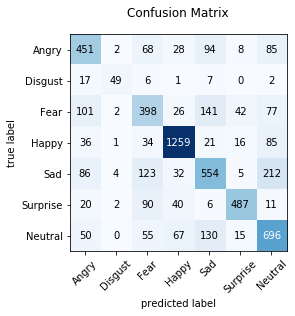

In [ ]:
# !pip install -U mlxtend > /dev/null 2>&1

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = cnn_model.predict(x_test)
y_predict = numpy.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

Then, let's try some other human facial expression images found online.


In [ ]:
# # Download into data folder
# os.chdir('/content/data')

# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ommGLsYSnmX8846iyQigKQfIfvpQzsF0' -O happy.jpg > /dev/null 2>&1
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1I1IjDm9Az4pkDqOz3zcQAguEJ1OsWagt' -O sad.jpg > /dev/null 2>&1
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZLglz_y0QklbYTcwJW1wH0YnAwBn6-1I' -O surprise.jpg > /dev/null 2>&1

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_facial_expression(image_path):
    """Predict facial expression for image"""
    # Open image
    rgb_image = image.load_img(path=image_path,
                            color_mode='grayscale',
                            target_size=(48, 48))
    # Convert to array
    rgb_array = image.img_to_array(rgb_image)
    rgb_array = numpy.expand_dims(rgb_array, axis=0)

    # Show image
    rgb_display = numpy.array(rgb_array, 'float32')
    rgb_display = rgb_display.reshape([48, 48]);
    plt.imshow(rgb_display, cmap='gray')
    plt.show()

    # Make predictions
    rgb_array = rgb_array / 255.0
    prediction = cnn_model.predict(rgb_array)

    # Draw the histogram
    plt.bar(y_pos, prediction[0], align='center', alpha=0.5)
    plt.xticks(y_pos, categories)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()

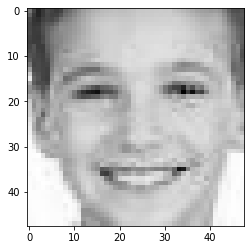

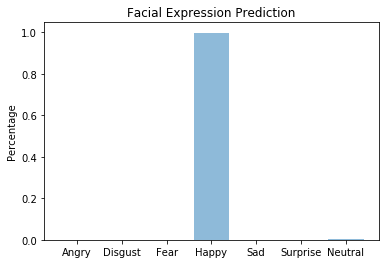

In [ ]:
# Happy
predict_facial_expression('emotion-detection-fer/train/happy/im0.png')

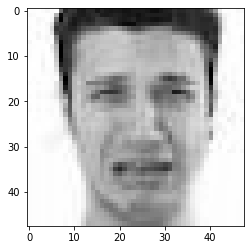

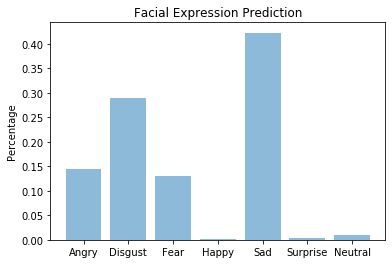

In [ ]:
# Sad
predict_facial_expression('emotion-detection-fer/train/sad/im0.png')

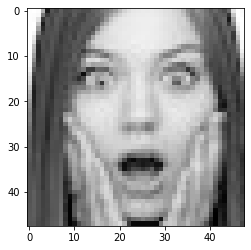

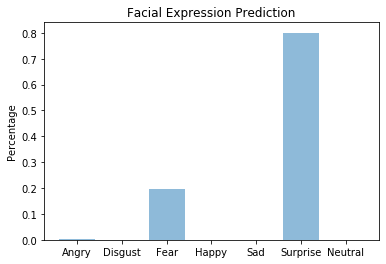

In [ ]:
# Surprise
predict_facial_expression('emotion-detection-fer/train/surprise/im0.png')

### Export Model

Last but not least, let's export the model, and save our TensorFlow and TensorFlow Lite model.

In [ ]:
# # Create build folder
# os.chdir('/content/')
# !rm -rf build
# !mkdir build
# os.chdir('build')
# !pwd

/content/build


In [ ]:
# Save tensorflow model
cnn_model.save('FER2013.h5')

In [ ]:
# # Save tensorflow lite model
# converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
# tflite_model = converter.convert()
# open("FER2013.tflite", "wb").write(tflite_model)

20406252

## Conclusion

To put it in a nutshell, Best Actor is a mobile game which integrates the computer vision technology using Convolutional Neural Network.